# **Toxic Comment Classification Challenge**

## 문제 소개

온라인에서 자신이 중요하게 생각하는 주제를 논의하는 것은 매우 어려울 수 있습니다. 학대와 괴롭힘의 위협은 많은 사람들이 자신의 의견을 표현하는 것을 멈추고, 다양한 의견을 탐색하는 것을 포기하게 만듭니다. 이러한 문제로 인해 많은 온라인 플랫폼과 커뮤니티는 대화를 효과적으로 촉진하는 데 어려움을 겪고 있으며, 결과적으로 사용자 댓글을 제한하거나 아예 차단하는 경우가 많습니다.

이 문제를 해결하기 위해 Jigsaw와 Google이 설립한 연구 이니셔티브인 Conversation AI 팀은 온라인 대화를 개선하기 위한 도구를 개발하고 있습니다. 이 팀은 특히 독성 댓글과 같은 부정적인 온라인 행동을 연구하는데 중점을 두고 있습니다. 독성 댓글이란 무례하고 존중하지 않으며, 누군가를 대화에서 떠나게 할 가능성이 높은 댓글을 말합니다. 지금까지 Conversation AI 팀은 Perspective API를 통해 독성을 포함한 다양한 공개 모델을 구축했지만, 현재 모델은 여전히 오류를 범하고 있으며 사용자가 특정 독성 유형을 선택할 수 없는 한계를 가지고 있습니다. 예를 들어, 어떤 플랫폼은 욕설을 허용하지만 다른 유형의 독성 콘텐츠는 허용하지 않을 수 있습니다.

## 도전 과제

Perspective API의 현재 모델보다 다양한 유형의 독성을 더 잘 감지할 수 있는 다중 헤드 모델을 구축하는 것입니다. 이러한 유형에는 위협, 외설, 모욕, 정체성 기반의 증오가 포함됩니다. 이를 위해 Wikipedia의 토크 페이지 편집에서 추출한 댓글 데이터셋을 사용할 것입니다. 이 대회에서의 개선을 통해 온라인 대화가 더 생산적이고 존중할 수 있게 되기를 바랍니다.

참가자들은 주어진 데이터셋을 사용하여 모델을 학습시키고, 테스트 세트의 각 댓글에 대해 여섯 가지 가능한 독성 유형(독성, 심각한 독성, 외설, 위협, 모욕, 정체성 기반 혐오) 각각에 대한 확률을 예측해야 합니다. 평가 기준은 각 독성 유형에 대한 ROC AUC의 평균 점수입니다.

toxic - 악플

severe_toxic - 심각한 악플

obscene - 외설적인 발언

threat - 위협

insult - 모욕

identity_hate - 정체성 혐오

## **라이브러리**

In [ ]:
import os  # 운영체제와 상호작용하기 위한 라이브러리, 파일 경로 조작 등
from typing import Tuple, List  # 타입 힌팅을 위한 모듈
from functools import partial  # 함수를 부분적으로 적용할 수 있도록 하는 유틸리티

import pandas as pd  # Data Frame
import numpy as np  # Matrix

# Preprocess (nltk)
import string, re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

# Transformer (BERT)
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, AdamW, get_linear_schedule_with_warmup

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Progress
from tqdm import tqdm

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

## **데이터 처리 과정**



## **데이터 로드 및 탐색**

In [ ]:
# 데이터 로드
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
train_df, val_df = train_test_split(train_df, test_size=0.05)

In [ ]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
10466,1ba7bf58ac07d6a0,Trolling \n\nMore trolling by Erwin Walsh\n\n...,0,0,0,0,0,0
54469,9196a6a4710c3fd6,"I added more references, softened the tone to ...",0,0,0,0,0,0
80062,d639672a866908f2,{{unblock|I basically think that certain peopl...,0,0,0,0,0,0
119349,7e0d985381aa32b2,Neither of these approaches is a good idea. Bl...,0,0,0,0,0,0
40350,6bad432832ea5018,"""\n\n References that you found for the 1481 ...",0,0,0,0,0,0


In [ ]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## **데이터 전처리**

텍스트 데이터를 정제하고 일관성을 준다

In [ ]:
punctuation = string.punctuation # 구두점
stop_word = set(stopwords.words('english')) # 불용어
lemmatizer = WordNetLemmatizer() # 형태소

def preprocess(data):
    data = data.lower()
    data = re.sub(r'http\S+|www\S+|https\S+', '', data, flags=re.MULTILINE) # 주소
    data = re.sub(r'\@\w+|\#','', data) # 언급 및 해시태그
    data = re.sub('[^a-zA-Z]', ' ', data) # 알파벳 외의 문자

    data = tokenizer.tokenize(data)

    data = [lemmatizer.lemmatize(word, "v") for word in data if word not in stop_word and word not in punctuation]
    data = [lemmatizer.lemmatize(word, "n") for word in data if word not in stop_word and word not in punctuation]
    data = [lemmatizer.lemmatize(word, "a") for word in data if word not in stop_word and word not in punctuation]
    return data

In [ ]:
train_df['text'] = train_df['comment_text'].apply(preprocess)

train_df.head()

## **데이터셋**

데이터셋 클래스를 통해 데이터의 전처리 및 로딩 방식을 통일하여 관리

데이터셋을 텐서로 변환하고 라벨을 처리하는 작업을 자동화하여 코드의 가독성과 유지보수성을 높임

In [ ]:
# 데이터셋 클래스 정의
class ToxicDataset(Dataset):
    def __init__(self, tokenizer, dataframe):
        self.tokenizer = tokenizer
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        tokens = self.tokenizer.encode(row["comment_text"], add_special_tokens=True, max_length=120, truncation=True)
        x = torch.tensor(tokens)
        y = torch.tensor(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]], dtype=torch.float)
        return x, y

# 데이터셋 생성
train_dataset = ToxicDataset(tokenizer, train_df)
val_dataset = ToxicDataset(tokenizer, val_df)

## **데이터로더**

데이터로더는 모델 학습 시 데이터를 배치 단위로 로드하여 메모리 효율성을 높이고 학습 속도를 개선

배치 처리와 셔플링을 통해 모델의 일반화 성능을 높임

collate_fn을 사용하여 각 배치의 시퀀스를 패딩하고, 텐서로 결합

In [ ]:
# 데이터로더 생성
def collate_fn(batch):
    x, y = zip(*batch)
    x = pad_sequence(x, batch_first=True, padding_value=tokenizer.pad_token_id)
    y = torch.stack(y)
    return x.to(device), y.to(device)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset), collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, sampler=RandomSampler(val_dataset), collate_fn=collate_fn)

## **Logistic Regression with Naïve Bayes**

Logistic Regression에 Naive Bayes를 적용시킨 모델의 학습 결과입니다.\
본래 logistic regression 대신 SVM(Support Vector Machine)을 사용하는 것이 적합하나, 본 challange에서는 logistic regression이 보다 높은 score를 기록하였습니다.\
\[참고\] [https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)

본 코드에서는 sklearn에서 제공되는 TfidfVectorizer와 LogisticRegression을 활용했습니다.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression

앞에서 소개한 데이터 전처리 코드를 활용하여 TF-IDF에 대한 binarized featured vector를 생성합니다.\
\[참고\]에서의 내용에 따르면, word unigram보다 word bigram feature에서 performance에 향상이 나타났으므로 word의 n-gram을 \[1, 2\]의 범위로 설정합니다.\
char n-grams도 모델의 성능 향상에 영향을 주므로, 적절한 값으로 vectorize합니다.

In [ ]:
word_vectorizer = TfidfVectorizer(
        ngram_range =(1, 2),
        min_df=3,
        max_df=0.9,
        tokenizer=preprocess,
        stop_words="english",
        analyzer="word"
)
char_vectorizer = TfidfVectorizer(ngram_range =(2, 5), max_features=50000, analyzer="char")

In [ ]:
train_text = train["comment_text"]
test_text = test["comment_text"]
all_text = pd.concat([train_text, test_text])

comment에 대한 train과 test 모두의 text에 대해 vocab을 생성하고, 이를 바탕으로 각각의 word 및 charactor에 대해 vectorize합니다.

In [ ]:
word_vectorizer.fit(all_text)
train_word_vector = word_vectorizer.transform(train_text)
test_word_vector = word_vectorizer.transform(test_text)

In [ ]:
char_vectorizer.fit(all_text)
train_char_vector = char_vectorizer.transform(train_text)
test_char_vector = char_vectorizer.transform(test_text)

In [ ]:
train_vector = hstack([train_word_vector, train_char_vector])
test_vector = hstack([test_word_vector, test_char_vector])

\[참고\]에 따르면, 각각의 toxic comment의 label에 대한 count vector는 다음과 같이 정의할 수 있습니다.

> $p = \alpha + \sum_{i : \{ y^{(i)} = 1 \} }$\
> $q = \alpha + \sum_{i : \{ y^{(i)} = 0 \} }$

이때의 $\alpha$는 smoothing parameter이며, 본 코드에서는 1로 사용되었습니다.\
위에서 얻어진 값들을 바탕으로, log-count ratio인 $r$은 다음과 같이 나타낼 수 있습니다.

> $r = log( \dfrac{p / ||p||_1}{q / ||q||_1} )$

이는 Naïve Bayes feature와 함께 logisitc regression을 계산하기 위해, feature count vector인 $f^{(k)}$에 다음 공식을 대입할 수 있습니다.

> $ x^{(k)} = \tilde{f}^{(k)} = r \circ f^{(k)} $

In [ ]:
def probability(train_vector, y_i, y):
    prob = train_vector[y == y_i].sum(axis=0)
    # laplace smoothing
    return (prob + 1) / ((y == y_i).sum() + 1)

In [ ]:
def NaiveBayes(train_vector, y):
    log_cnt = np.log(probability(train_vector, 1, y) / probability(train_vector, 0, y))
    nb = train_vector.multiply(log_cnt)
    return nb, log_cnt

위의 내용들을 바탕으로 Logistic Regression에 naive bayes를 적용한 코드는 다음과 같습니다.

In [ ]:
model = LogisticRegression(C=0.1, max_iter=2000)

In [ ]:
for label in labels:
    y = train_class[label].values
    nb, log_cnt = NaiveBayes(train_vector, y)

    model.fit(nb, y)

    y_pred = model.predict(train_vector.multiply(log_cnt))
    print('Training accuracy for {} is {}'.format(label, accuracy_score(y, y_pred)))

    test_y_prob = model.predict_proba(test_vector.multiply(log_cnt))[:, 1]
    submission[label] = test_y_prob

Training accuracy for toxic is 0.9620106410312651
Training accuracy for severe_toxic is 0.9923733009130732
Training accuracy for obscene is 0.981262259433105
Training accuracy for threat is 0.9976875497427478
Training accuracy for insult is 0.9750518577937094
Training accuracy for identity_hate is 0.9935577266545926


Logistic Regression with Naïve Bayes를 적용한 model의 결과와 score는 다음과 같습니다.

In [ ]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999439,0.128199,0.999150,0.010256,0.969730,0.118215
1,0000247867823ef7,0.025719,0.003005,0.010681,0.001024,0.012646,0.003113
2,00013b17ad220c46,0.026739,0.003238,0.010651,0.001034,0.010653,0.002692
3,00017563c3f7919a,0.007810,0.001782,0.005738,0.001415,0.006651,0.001993
4,00017695ad8997eb,0.032932,0.002264,0.010005,0.000965,0.011337,0.002083


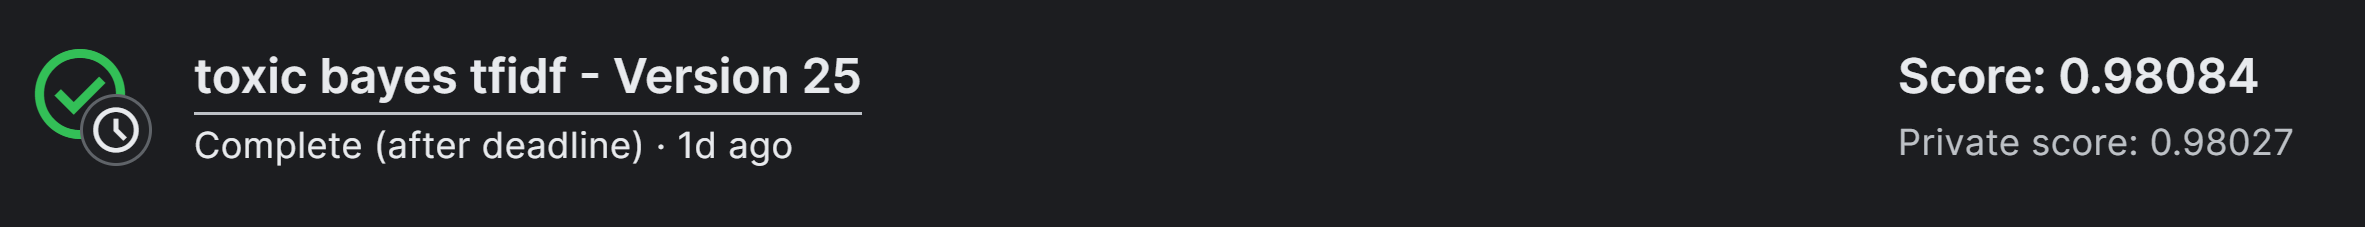

## **CNN**

###데이터 전처리


텍스트를 토큰화 시킨 이후에 정수시퀀스로 변환, 또한 길이를 맞추기 위한 padding 적용

In [ ]:
# 토크나이저 정의
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['comment_text'])

# 텍스트를 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(train_df['comment_text'])
X_test = tokenizer.texts_to_sequences(test_df['comment_text'])

# 패딩 적용
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


## **cnn 모델**

이미지에서 특성을 추출하듯 텍스트 데이터의 다양한 특성들을 추출 가능하다고 생각해 모델 적용

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv1 = nn.Conv1d(embed_size, 64, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * ((max_len - 5 + 1) // 2), 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

vocab_size = max_words
embed_size = 128
num_classes = 6

model = CNNModel(vocab_size, embed_size, num_classes)

## **정확도와 결과 고찰**

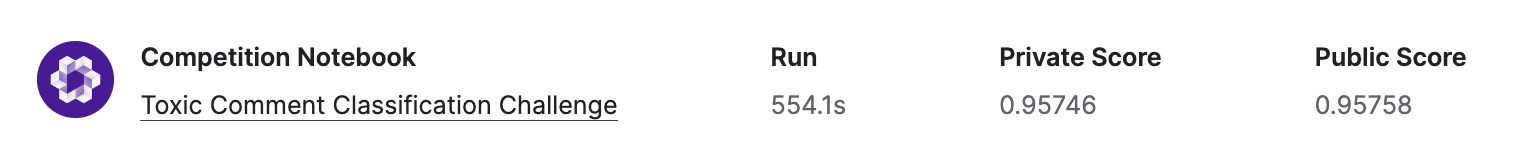


## 정확도가 현격히 떨어짐

###모델에서의 문제로는 다음과 같다.


*   다중 합성곱 레이어 가 아닌 단일 레이어
*   사전 훈련된 임베딩 (Word2Vec, GloVe) 사용 X

#### 이미 사전에 올라와 있는 코드들 중 cnn을 단독 사용한 코드의 점수가 낮았음

###즉 이번문제에서 cnn 모델의 단점이 분명함


*   긴 문장에 대해 유연하게 처리 할 수 없었음
*   문맥 파악에서의 약점










RNN

In [ ]:
# hyperparams
TEXT_LENGTH = 128
EMBEDDING_SIZE = 50
# EMBEDDING_SIZE = 200
BATCH_SIZE = 32  #64
VOCAB_SIZE=25000

In [ ]:
#TEXT ,와 LABEL 이 처리 방법을 알려주는 field 라고 볼 수 있다. (tensor)
#소문자화하고 sequence 길이 고정하고 위에서 정의한 tokenizer을 가지고 token화 하는 역할
TEXT = data.Field(lower=True, batch_first=True,fix_length=TEXT_LENGTH, preprocessing=None, tokenize=tokenizer)
LABEL = data.Field(sequential=False,is_target=True, use_vocab=False, pad_token=None, unk_token=None)

#각 column을 어떤 field를 가지고 처리할 것인지에 대하여 정한다.
datafields = [('id', None),
              ('comment_text', TEXT),
              ("toxic", LABEL),
              ("severe_toxic", LABEL),
              ('obscene', LABEL),
              ('threat', LABEL),
              ('insult', LABEL),
              ('identity_hate', LABEL)]


alldata = TabularDataset(
    path='/kaggle/input/train-csv/train.csv',
    format='csv',
    skip_header=True,
    fields=datafields,)

In [ ]:
random.seed(17)
train,dev = alldata.split(split_ratio=0.8, random_state=random.getstate()) #초기값은 0.9 였음

In [ ]:
#단어집을 구성하는 함수이다. 최대 사이즈는 25000이고 최소 5번 이상 나온 것으로 생성을 하는 것이다.

TEXT.build_vocab(train, max_size=25000, min_freq=5)

In [ ]:
print(len(TEXT.vocab))

25002


In [ ]:
class NNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx, embeddings, text_length, lstm_hidden_size):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size,embedding_dim,pad_idx)
        self.lstm = nn.GRU(input_size=embedding_dim, hidden_size=lstm_hidden_size, num_layers=1,bidirectional = True, batch_first=True)
        self.max_pool = nn.MaxPool2d((text_length,1))
        self.fc1 = nn.Linear(lstm_hidden_size*2, 100)
        self.fc2 = nn.Linear(100, output_dim)

    def forward(self, text):
        a1 = self.embeddings(text)
        a2 = self.lstm(a1)[0]
        a3 = self.max_pool(a2).squeeze(1)
        a4 = F.relu(self.fc1(a3))
        a5 = self.fc2(a4)
        return a5

In [ ]:
random.seed(1234)
train_iterator, valid_iterator = data.BucketIterator.splits((train, dev),
                                                            batch_size=BATCH_SIZE,
                                                            device=device,
                                                            shuffle=True,
                                                            sort_key=lambda x: len(x.comment_text))

In [ ]:
OUTPUT_DIM = 6
#패딩토큰의 위치 -> 임베딩에서 0으로 설정하기 위함
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
model = NNet(len(TEXT.vocab), EMBEDDING_SIZE, OUTPUT_DIM, PAD_IDX, TEXT.vocab.vectors,TEXT_LENGTH, 150).to(device)


1
The model has 1,462,606 trainable parameters


In [ ]:
def fit_epoch(iterator, model, optimizer, criterion):
    train_loss = 0
    train_acc = 0
    model.train()
    all_y = []
    all_y_hat = []
    for batch in iterator:
        optimizer.zero_grad()
        y = torch.stack([batch.toxic,
                         batch.severe_toxic,
                         batch.obscene,
                         batch.threat,
                         batch.insult,
                         batch.identity_hate],dim=1).float().to(device)
        y_hat = model(batch.comment_text.to(device))
        loss = criterion(y_hat, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        all_y.append(y)
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    roc = roc_auc_score(y.cpu(),y_hat.sigmoid().detach().cpu())
    return train_loss / len(iterator.dataset), roc

def test_epoch(iterator, model, criterion):
    train_loss = 0
    train_acc = 0
    model.eval()
    all_y = []
    all_y_hat = []
    for batch in iterator:
        y = torch.stack([batch.toxic,
                         batch.severe_toxic,
                         batch.obscene,
                         batch.threat,
                         batch.insult,
                         batch.identity_hate],dim=1).float().to(device)
        with torch.no_grad():
            y_hat = model(batch.comment_text.to(device))
        loss = criterion(y_hat, y)
        train_loss += loss.item()
        all_y.append(y)
        all_y_hat.append(y_hat)
    y = torch.cat(all_y,dim=0)
    y_hat = torch.cat(all_y_hat,dim=0)
    roc = roc_auc_score(y.cpu(),y_hat.sigmoid().detach().cpu())
    return train_loss / len(iterator.dataset), roc

In [ ]:
def train_n_epochs(n, lr, wd):

    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for epoch in range(n):
        start_time = time.time()
        train_loss, train_roc = fit_epoch(train_iterator, model, optimizer, criterion)
        valid_loss, valid_roc = test_epoch(valid_iterator, model, criterion)

        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60

        print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\troc: {train_roc :.6f} (train)')
        print(f'\tLoss: {valid_loss:.4f}(valid)\t|\troc: {valid_roc:.6f} (valid)')

In [ ]:
# train_n_epochs(3,0.01,0)
train_n_epochs(5,0.001,0)

Epoch: 1  | time in 1 minutes, 15 seconds
	Loss: 0.0023(train)	|	roc: 0.931391 (train)
	Loss: 0.0018(valid)	|	roc: 0.967056 (valid)
Epoch: 2  | time in 1 minutes, 15 seconds
	Loss: 0.0016(train)	|	roc: 0.971986 (train)
	Loss: 0.0016(valid)	|	roc: 0.976161 (valid)
Epoch: 3  | time in 1 minutes, 15 seconds
	Loss: 0.0014(train)	|	roc: 0.981997 (train)
	Loss: 0.0016(valid)	|	roc: 0.979153 (valid)
Epoch: 4  | time in 1 minutes, 15 seconds
	Loss: 0.0012(train)	|	roc: 0.987440 (train)
	Loss: 0.0015(valid)	|	roc: 0.980125 (valid)
Epoch: 5  | time in 1 minutes, 15 seconds
	Loss: 0.0011(train)	|	roc: 0.991679 (train)
	Loss: 0.0015(valid)	|	roc: 0.979581 (valid)


# **BERT**


#### bert 의 장점

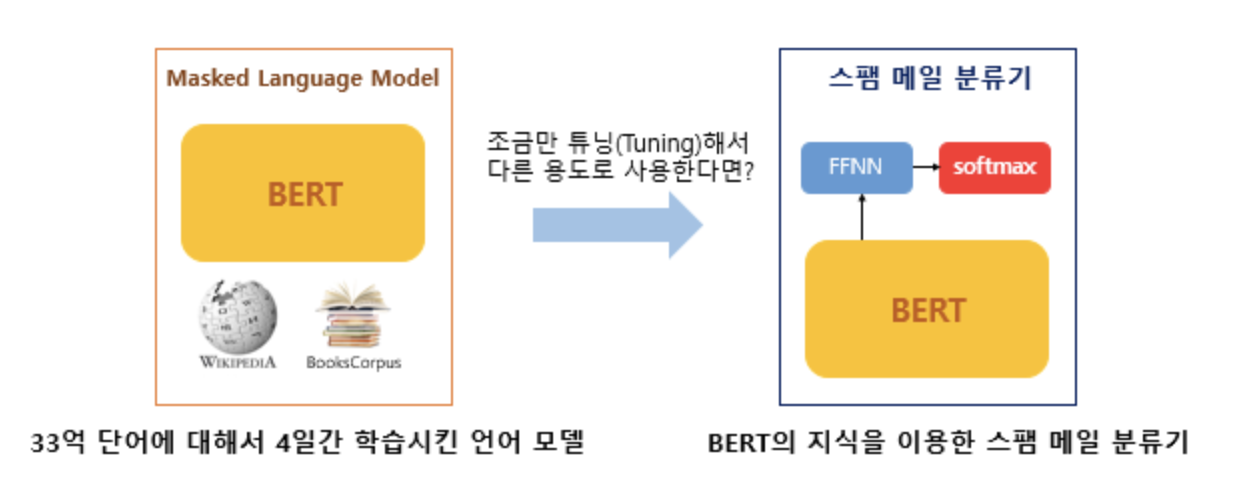



미리 33억개 단어의 데이터에 대해서 미리 학습된 모델을 사용 할 수 있음

또한 양방향 학습이 가능에 문장 파악에 강점을 가짐


//출처 https://wikidocs.net/115055

## **데이터 전처리**

overfitting 을 방지하기 위해 train_test_split 을 사용해서 5% 를 vaild로 분리

BertTokenizer는 wordpiece tokenizer 를 사용해 데이터를 줄여주고

특수토큰 을 추가해서 bert 모델이 문장 관계를 잘 학습 할 수 있도록 함

[CLS] : 문장 시작, [SEP] : 문장 중간, 끝  

In [ ]:
# 데이터 로드
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
train_df, val_df = train_test_split(train_df, test_size=0.05)

# 토크나이저 설정
tokenizer = BertTokenizer.from_pretrained(bert_model_name)


## **bert 모델**

bert 모델은 base를 사용함

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        cls_output = self.classifier(cls_output)
        return torch.sigmoid(cls_output)

model = BertClassifier(bert_model_name, 6).to(device)

## 정확도와 고찰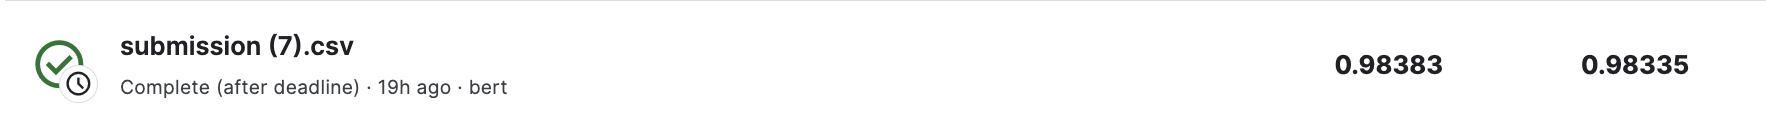


## 정확도가 그동안의 모델보다 월등함

고득점 모델들은 모두 Bi-GRU,LSTM 와 같이 양방향 학습이 가능한 모델들이였음

toxic 분류 문제에선 양방향 학습이 유리하다고 생각됨



### 발전할 부분

모델이 bert-base 이기때문에 다양한 bert 모델을 적용시켜 볼 필요가 있음

RoBERTa, ALBERT, ELECTRA 등등



## 아쉬운점

데이터 전처리가 부족하면 bert tokenize 에서의 문제가 보였음

예를들어 tofuck 이라는 데이터를 to fuck 이라고 전처리가 되야 하지만 그렇지 못해서

tof , ##uck 로 나뉘어 욕설을 욕설로 보지 않는 경우가 종종 발생함

사용자의 댓글에서 이런 오류가 있을 수 있음을 걸러내지 못했음


## **Score 비교** ##

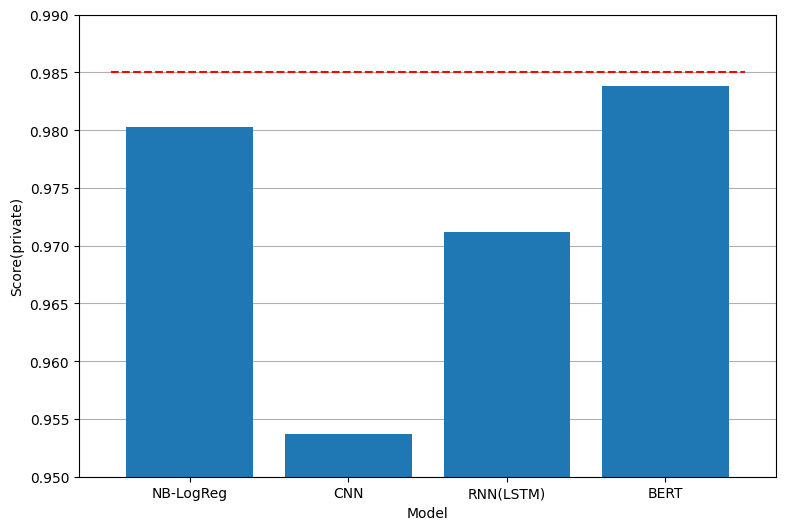